### Required activity 25.3: Portfolio project on optimising a model for real-life data

This project will be built with aim of predicting stock prices using Long Short Term Memory (LSTM). 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sb
import datetime
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

now = datetime.now().date()
startdate = now - timedelta(days=365*10) # 10 years

### Part 1. Obtaining a dataset

yfinance offers a threaded and Pythonic way to download market data from Yahoo!Ⓡ finance. 

1. https://github.com/ranaroussi/yfinance


This enable us to download day to day market data when market closes. Some other data that can be downloaded are..

1. dividends 
2. splits
3. capital gains
4. share count
5. income statement
6. quarterly income statement
7. quarterly balance sheet
8. quarterly cashflow
9. major share holders
10. news
11. and more...

For simplicity sake, we will be using just Tesla stock's closing price.

In [2]:
# 1. Fetch Historical Stock Prices
tsla = yf.Ticker("TSLA")
tsla_price = tsla.history(start=startdate)
tsla_price.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-27 00:00:00-04:00,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0
2014-05-28 00:00:00-04:00,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0
2014-05-29 00:00:00-04:00,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0
2014-05-30 00:00:00-04:00,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0
2014-06-02 00:00:00-04:00,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0


In [3]:
tsla_price.index = tsla_price.index.strftime('%Y-%m-%d')
tsla_price.index = pd.to_datetime(tsla_price.index)
tsla_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-14,174.500000,179.490005,174.070007,177.550003,86407400,0.0,0.0
2024-05-15,179.899994,180.000000,173.110001,173.990005,79663000,0.0,0.0
2024-05-16,174.100006,175.789993,171.429993,174.839996,59812200,0.0,0.0


In [4]:
nasdaq = yf.Ticker("^IXIC")
sp500 = yf.Ticker("^GSPC")

nasdaq_price = nasdaq.history(start=startdate)
sp500_price = sp500.history(start=startdate)

nasdaq_price.index = nasdaq_price.index.strftime('%Y-%m-%d')
nasdaq_price.index = pd.to_datetime(nasdaq_price.index)

sp500_price.index = sp500_price.index.strftime('%Y-%m-%d')
sp500_price.index = pd.to_datetime(sp500_price.index)

tsla_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-14,174.500000,179.490005,174.070007,177.550003,86407400,0.0,0.0
2024-05-15,179.899994,180.000000,173.110001,173.990005,79663000,0.0,0.0
2024-05-16,174.100006,175.789993,171.429993,174.839996,59812200,0.0,0.0


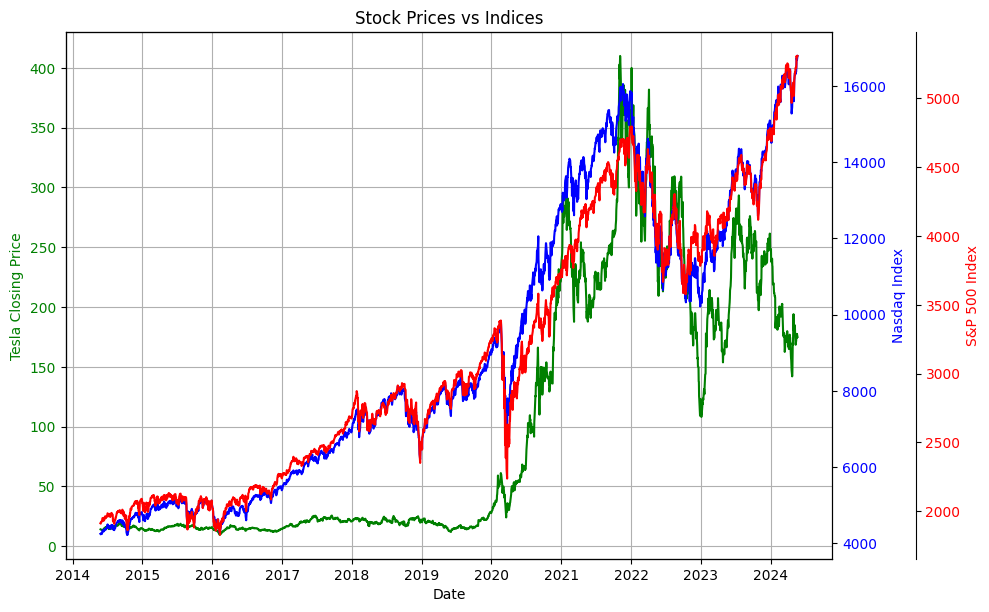

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(tsla_price['Close'], label='Tesla Closing Price', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(nasdaq_price['Close'], label='Nasdaq', color='b')
ax2.set_ylabel('Nasdaq Index', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(sp500_price['Close'], label='S&P 500', color='r')
ax3.set_ylabel('S&P 500 Index', color='r')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Stock Prices vs Indices')
plt.show()

Tesla was included in nasdaq after it's IPO on 29/06/2010 since it was listed on nasdaq exchange. It was subsequently added to SP500 on 21/12/2020. 

From the plot, the trend was observed to be broken off during 2023

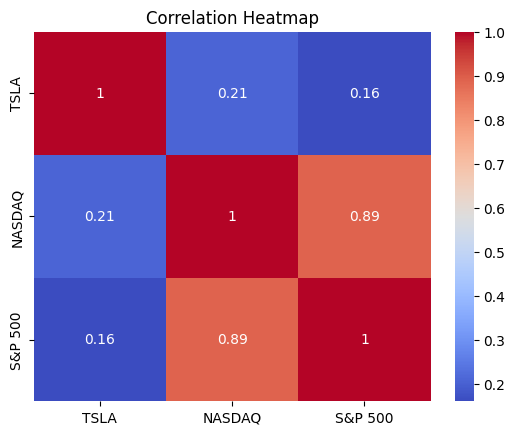

In [6]:
data = pd.DataFrame({
    'TSLA': tsla_price['Close'],
    'NASDAQ': nasdaq_price['Close'],
    'S&P 500': sp500_price['Close']
})

filtered_data = data.loc['2020-12-21':]

correlation = filtered_data.corr(method='spearman')
sb.heatmap(correlation, annot=True, cmap='coolwarm')

# Add titles and labels
plt.title("Correlation Heatmap")
plt.show()

### Part 2. Exploratory Data Analysis (EDA)


It is possible to use multiple features to train LSTM. We can explore what about features can be used.

In [7]:
print(f"Total records are {tsla_price['Close'].shape[0]}."
      f"\nNull check \n{tsla_price.isna().sum()}")

Total records are 2514.
Null check 
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


Other technical indicators and metrics that can help with prediction. 

1. Moving Average Convergence Divergence (MACD) - 
2. Relative Strength Index (RSI) - _Result of stock price_
3. On-Balance Volume (OBV) - _Perhaps doesn't align with short term strategy_
4. Chaikin Money Flow(CMF) - _Perhaps doesn't align with short term strategy_
5. Fibonacci Retracements
6. News Sentiment Analysis
7. and more...

A few consideration for the algorithm are.
1. Not to short a equity (or till model are in higher confidence) to limit potential losses.
2. RSI below 30 should trigger a higher aggressive technical
3. Crossover of MACD line should trigger a higher aggressive technical. Recommended to wait for 3-4 days to confirm __NOT__ a false positive
4. Fibonacci Retracements should support a slightly higher aggressive technical on each level. Most commonly used ratios include 23.6%, 38.2%, 50%, 61.8%, and 78.6

These pointers are what humans can observe. Using deep learning algorithms (RNN-LSTM), more pattern could potentially be uncovered.

In [8]:
#MACD with traditional setting (26/12/9). The signal line is a nine-period EMA of the MACD line.
def compute_macd(tsla_price, short_window=12, long_window=26, signal_window=9):
    data = tsla_price.copy()
    short_ema = tsla_price['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = tsla_price['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD line
    data.loc[:, 'MACD'] = short_ema - long_ema
    # Signal Line
    data.loc[:, 'Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

df = compute_macd(tsla_price)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line
Date,,,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0,0.000000,0.000000
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0,-0.007020,-0.001404
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0,-0.012440,-0.003611
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0,-0.029680,-0.008825
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0,-0.059176,-0.018895


In [9]:
#RSI with Exponential Weighted Function(ewm) which give weights to values.
def compute_rsi(tsla_price, window):
    delta = tsla_price.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.ewm(min_periods=window, adjust=False, alpha=1/window).mean()
    avg_loss = loss.ewm(min_periods=window, adjust=False, alpha=1/window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI'] = compute_rsi(tsla_price['Close'], 14)
df.head() # Notice the first 13 rows RSI are NaN due to calculation window

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line,RSI
Date,,,,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0,0.000000,0.000000,NaN
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0,-0.007020,-0.001404,NaN
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0,-0.012440,-0.003611,NaN
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0,-0.029680,-0.008825,NaN
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0,-0.059176,-0.018895,NaN


In [10]:
naLen = df['RSI'].isna().sum()
naLen

13

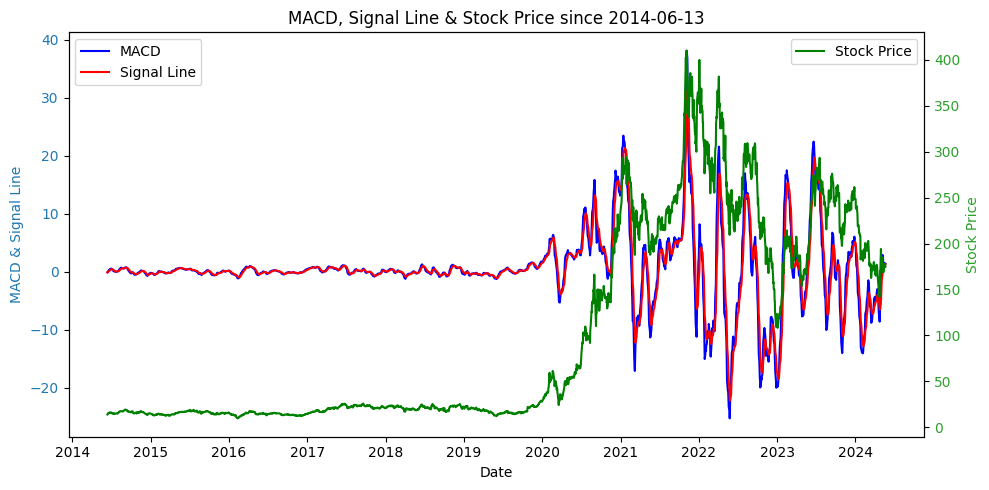

In [11]:
filtered_df = df[naLen:]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('MACD & Signal Line', color='tab:blue')
ax1.plot(filtered_df.index, filtered_df['MACD'], label='MACD', color='blue')
ax1.plot(filtered_df.index, filtered_df['Signal_Line'], label='Signal Line', color='red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stock Price', color='tab:green')  
ax2.plot(filtered_df.index, filtered_df['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"MACD, Signal Line & Stock Price since {filtered_df.index[0].strftime('%Y-%m-%d')}")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  
plt.show()

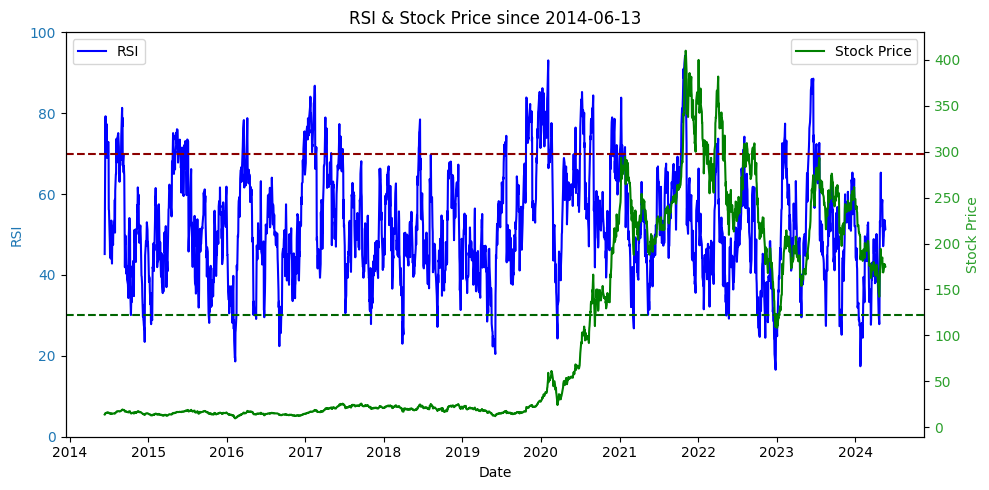

In [12]:
# Plotting RSI and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('RSI', color='tab:blue')
ax1.plot(filtered_df.index, filtered_df['RSI'], label='RSI', color='blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.axhline(y=70, color='darkred', linestyle='--')  # Overbought level
ax1.axhline(y=30, color='darkgreen', linestyle='--')  # Oversold level

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Stock Price', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(filtered_df.index, filtered_df['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"RSI & Stock Price since {filtered_df.index[0].strftime('%Y-%m-%d')}")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [13]:
print(f"Total records are {filtered_df.shape[0]}."
      f"\nNull check \n{filtered_df.isna().sum()}")

Total records are 2501.
Null check 
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
MACD            0
Signal_Line     0
RSI             0
dtype: int64


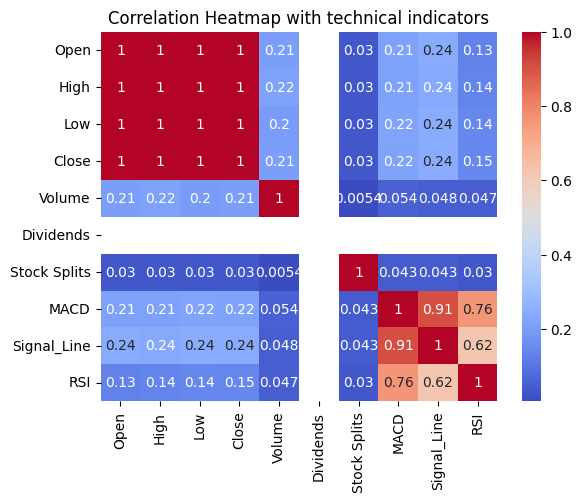

In [14]:
correlation = filtered_df.corr(method='spearman')
sb.heatmap(correlation, annot=True, cmap='coolwarm')

# Add titles and labels
plt.title("Correlation Heatmap with technical indicators")
plt.show()

In [15]:
filtered_df['Dividends'].sum()

0.0

In [16]:
filtered_df = filtered_df.drop(columns='Dividends', axis = 1)
filtered_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Stock Splits', 'MACD',
       'Signal_Line', 'RSI'],
      dtype='object')

We can observe that from the seaborn plot that MACD, Signal Line and RSI are all highly correlated to each other and will impact the model's performance.

For a simple approach, we will be using just the 'Closing' price for LSTM. 

### Part 3. ML techniques and data partition
Recurrent Neural Networks (RNNs) are designed to handle sequences of variable lengths, making them particularly suitable for tasks like predicting future values in a sequence. They maintain an internal state that can capture information about previous elements in the sequence, allowing them to remember important parts and potentially forget less crucial details over time.


However, traditional RNNs suffer from challenges related to the vanishing and exploding gradient problems, especially when processing long sequences. These issues hinder RNN’s ability to learn from distant past information in the sequence.


To address this, __Long Short-Term Memory (LSTM)__ networks were introduced. LSTMs are a special kind of RNN that can learn and remember over long sequences and are not as susceptible to the vanishing gradient problem as standard RNNs. This makes them more efficient at capturing long-term dependencies in sequence data.

Allocation of data for training are
1. Train: 80%
2. Test: Last 5 days will be used for testing.
3. Validation: Takes the rest

Project is a regression problem, hence we will be testing out performance metrics.
1. Mean Square Error (MSE)

In [17]:
# 2. Preprocess the Data
df = tsla_price[['Close']]
# df = filtered_df[['MACD']]

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(df.values.reshape(-1, 1))

Hyperparameters for the LSTM are: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01, 'epochs': 100, 'window': 10}
Epoch [50/100], Training loss: 0.0030
Epoch [100/100], Training loss: 0.0018
MSE Test Loss: 0.0030



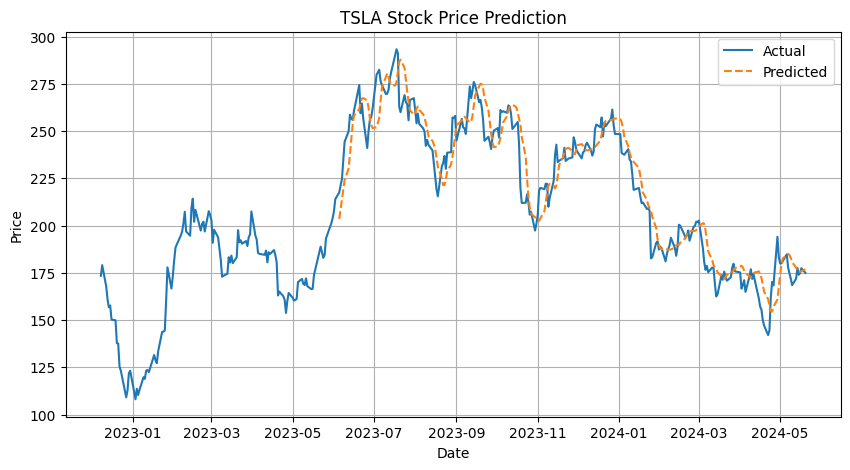

In [18]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Prepare data function
def prepare_data(data_normalized, window):
    data_len = len(data_normalized)
    train_ratio = 0.90
    train_len = int(data_len * train_ratio)

    X_train, y_train = [], []
    X_test, y_test = [], []

    # Training data
    for i in range(train_len - window):
        X_train.append(data_normalized[i:i + window])
        y_train.append(data_normalized[i + window])

    # Test data 
    for i in range(train_len, data_len - window):
        X_test.append(data_normalized[i:i + window])
        y_test.append(data_normalized[i + window])

#     print(f"Training Size: {len(X_train)}, Testing Size: {len(X_test)}, Window Size: {window}")
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Plot prediction against actual data
def plot(tsla_price, predicted_prices, len_test):
    plot_len = int(len_test * 1.5)
    
    plt.figure(figsize=(10, 5))
    plt.plot(tsla_price.index[-plot_len:], tsla_price['Close'].values[-plot_len:], label='Actual')
    plt.plot(tsla_price.index[-len_test:], predicted_prices, label='Predicted', linestyle='dashed')
    
    plt.title('TSLA Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main(X_train, y_train, X_test, y_test, hyperparameters):
    hidden_dim = hyperparameters['hidden_dim']
    num_layers = hyperparameters['num_layers']
    dropout = hyperparameters['dropout']
    learning_rate = hyperparameters['learning_rate']
    epochs = hyperparameters['epochs']
    print(f"Hyperparameters for the LSTM are: {hyperparameters}")

    # Convert numpy arrays to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    torch.manual_seed(42)

    # Initialize model
    model = LSTM(input_dim=1, output_dim=1, 
                 hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Training loss: {loss.item():.4f}')

    # Use the last window from the test set to predict the entire test set
    model.eval()
    with torch.no_grad():
        predicted_prices = []
        for i in range(len(X_test)):
            input_data = X_test[i].unsqueeze(0)
            output = model(input_data)
            predicted_prices.append(output.item())
    
    # Convert predicted_prices to a PyTorch tensor and ensure it matches y_test shape
    predicted_prices_tensor = torch.tensor(predicted_prices, dtype=torch.float32).view(-1, 1)
    
    # Compute MSE
    mse_loss = criterion(predicted_prices_tensor, y_test)
    print(f"MSE Test Loss: {mse_loss.item():.4f}\n")

    # Convert predicted_prices to numpy array
    predicted_prices = scaler.inverse_transform(predicted_prices_tensor.numpy().reshape(-1, 1)).flatten()

    return predicted_prices, mse_loss.item(), model

if __name__ == '__main__':
    hyperparameters = {
        'hidden_dim': 128,
        'num_layers': 2,
        'dropout': 0.2, # Removed on version 2
        'learning_rate': 0.01,
        'epochs': 100,
        'window': 10  # Window is not a hyperparameter; it's a feature engineering as input config
    }
    
    X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
    predicted_prices, mse_loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
    # Plot prediction
    plot(df, predicted_prices, len(X_test))


In [ ]:
# pip install optuna
import optuna
from optuna.trial import Trial

# Optuna objective function
def objective(trial: Trial):
    hyperparameters = {
        'hidden_dim': trial.suggest_int('hidden_dim', 50, 300),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 50, 300),
        'window': trial.suggest_int('window', 5, 20)
    }

    X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
    _, mse_loss, _ = main(X_train, y_train, X_test, y_test, hyperparameters)
    return mse_loss

# # Run Optuna optimization
if __name__ == '__main__':

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=5)

    best_hyperparameters = study.best_params
    print("Best hyperparameters found: ", best_hyperparameters)

    # Train the final model with the best hyperparameters
    X_train, y_train, X_test, y_test = prepare_data(data_normalized, best_hyperparameters['window'])
    predicted_prices, mse_loss, model = main(X_train, y_train, X_test, y_test, best_hyperparameters)
        
    # Save the best performing model
    model_path = 'best_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    # Plot prediction
    plot(df, predicted_prices, len(X_test))

[I 2024-05-21 11:46:36,335] A new study created in memory with name: no-name-47078584-9a8a-4345-946c-017feb2fb5c9


Hyperparameters for the LSTM are: {'hidden_dim': 255, 'num_layers': 3, 'dropout': 0.4749282605496947, 'learning_rate': 0.03508354987830887, 'epochs': 127, 'window': 11}


Best hyperparameter found via optuna are

{'hidden_dim': 270, 'num_layers': 2, 'dropout': 0.40157739382028523, 'learning_rate': 0.028986462884432136, 'epochs': 236, 'window': 6}

Model are saved and optimizing step are commented out to avoid re-running due to extensive computation. 

In [ ]:
# Load the model and predict 7 days ahead
def predict_7_days_ahead(model, data, window, scaler):
    model.eval()
    with torch.no_grad():
        predictions = []
        input_seq = torch.tensor(data[-window:], dtype=torch.float32).unsqueeze(0)
        for _ in range(7):
            output = model(input_seq)
            predictions.append(output.item())
            input_seq = torch.cat((input_seq[:, 1:, :], output.unsqueeze(0).unsqueeze(0)), dim=1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# best_hyperparameters = {
#     'hidden_dim': 270, 
#     'num_layers': 2, 
#     'dropout': 0.40157739382028523, 
#     'learning_rate': 0.028986462884432136, 
#     'epochs': 236, 
#     'window': 6
# }

# Reload the model with the best hyperparameters
model = LSTM(input_dim=1, output_dim=1, 
             hidden_dim=best_hyperparameters['hidden_dim'], 
             num_layers=best_hyperparameters['num_layers'], 
             dropout=best_hyperparameters['dropout'])

model_path = 'best_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Predict 7 days ahead
future_predictions = predict_7_days_ahead(model, data_normalized, 
                                          best_hyperparameters['window'], scaler)
print("7-day ahead predictions: ", future_predictions)

# Plot the predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(pd.date_range(start=df.index[-1], periods=8, closed='right'), 
         np.concatenate(([df['Close'].iloc[-1]], future_predictions)), 
         label='7-Day Prediction', linestyle='dashed')
plt.title('TSLA Stock Price Prediction with 7-Day Look Ahead')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load the best hyperparameters (these should match the best hyperparameters found during Optuna optimization)
best_hyperparameters = {
    'hidden_dim': 270, 
    'num_layers': 2, 
    'dropout': 0.40157739382028523, 
    'learning_rate': 0.028986462884432136, 
    'epochs': 236, 
    'window': 6
}

In [ ]:
# Print keys for debugging
print("Keys in state_dict:")
for key in state_dict.keys():
    print(key)

# Print model's state_dict keys
print("\nKeys in model's state_dict:")
for key in model.state_dict().keys():
    print(key)

In [ ]:
hyperparameters = best_hyperparameters 
X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
predicted_prices, mse_loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
# Plot prediction
plot(df, predicted_prices, len(X_test))

In [ ]:
# '''
# DO NOT DELETE
# '''


# # Define LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
#         out, _ = self.lstm(x, (h0, c0))
#         return self.fc(out[:, -1, :])

# # Prepare data function
# def prepare_data(data_normalized, window):
#     data_len = len(data_normalized)
#     train_ratio = 0.90
#     train_len = int(data_len * train_ratio)

#     X_train, y_train = [], []
#     X_test, y_test = [], []

#     # Training data
#     for i in range(train_len - window):
#         X_train.append(data_normalized[i:i + window])
#         y_train.append(data_normalized[i + window])

#     # Test data 
#     for i in range(train_len, data_len - window):
#         X_test.append(data_normalized[i:i + window])
#         y_test.append(data_normalized[i + window])

#     print(f"Training Size: {len(X_train)}, Testing Size: {len(X_test)}, Window Size: {window}")
    
#     return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# # Plot prediction against actual data
# def plot(tsla_price, predicted_prices, len_test):
#     plot_len = int(len_test * 1.5)
    
#     plt.figure(figsize=(10, 5))
#     plt.plot(tsla_price.index[-plot_len:], tsla_price['Close'].values[-plot_len:], label='Actual')
#     plt.plot(tsla_price.index[-len_test:], predicted_prices, label='Predicted', linestyle='dashed')
    
#     plt.title('TSLA Stock Price Prediction')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Main function
# def main(X_train, y_train, X_test, y_test, hyperparameters):
#     hidden_dim = hyperparameters['hidden_dim']
#     num_layers = hyperparameters['num_layers']
#     learning_rate = hyperparameters['learning_rate']
#     epochs = hyperparameters['epochs']
#     print(f"Hyperparameters for the LSTM are: {hyperparameters}")

#     # Convert numpy arrays to tensors
#     X_train = torch.tensor(X_train, dtype=torch.float32)
#     y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#     X_test = torch.tensor(X_test, dtype=torch.float32)
#     y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
#     torch.manual_seed(42)

#     # Initialize model
#     model = LSTM(input_dim=1, output_dim=1, hidden_dim=hidden_dim, num_layers=num_layers)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # Training loop
#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train)
#         loss.backward()
#         optimizer.step()
        
#         if (epoch + 1) % 50 == 0:
#             print(f'Epoch [{epoch + 1}/{epochs}], Training loss: {loss.item():.4f}')

#     # Use the last window from the test set to predict the entire test set
#     model.eval()
#     with torch.no_grad():
#         predicted_prices = []
#         for i in range(len(X_test)):
#             input_data = X_test[i].unsqueeze(0)
#             output = model(input_data)
#             predicted_prices.append(output.item())
    
#     # Convert predicted_prices to a PyTorch tensor and ensure it matches y_test shape
#     predicted_prices_tensor = torch.tensor(predicted_prices, dtype=torch.float32).view(-1, 1)
    
#     # Compute MSE
#     mse_loss = criterion(predicted_prices_tensor, y_test)
#     print(f"MSE Test Loss: {mse_loss.item():.4f}")

#     # Convert predicted_prices to numpy array
#     predicted_prices = scaler.inverse_transform(predicted_prices_tensor.numpy().reshape(-1, 1)).flatten()

#     return predicted_prices, mse_loss.item(), model

# if __name__ == '__main__':
#     hyperparameters = {
#         'hidden_dim': 128,
#         'num_layers': 2,
#         'learning_rate': 0.01,
#         'epochs': 100,
#         'window': 10  # Window is not a hyperparameter; it's a feature engineering as input config
#     }

#     X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
#     predicted_prices, mse_loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
#     # Plot prediction
#     plot(df, predicted_prices, len(X_test))


In [ ]:
# # Define LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out = self.fc(out[:, -1, :])
#         return out

# # Prepare data function
# def prepare_data(data_normalized, window):
#     data_len = len(data_normalized)
#     train_ratio = 0.90
#     train_len = int(data_len * train_ratio)

#     X_train, y_train = [], []
#     X_test, y_test = [], []

#     # Training data
#     for i in range(train_len - window):
#         X_train.append(data_normalized[i:i + window])
#         y_train.append(data_normalized[i + window])

#     # Test data 
#     test_start = train_len  
#     for i in range(test_start, data_len - window):
#         X_test.append(data_normalized[i:i + window])
#         y_test.append(data_normalized[i + window])

#     print(f"Training Size: {len(X_train)}, Testing Size: {len(X_test)}, Window Size: {window}")
    
#     return (
#         np.array(X_train), np.array(y_train),
#         np.array(X_test), np.array(y_test)
#     )


# # Plot prediction against actual data
# def plot(tsla_price, predicted_prices, len_test):
#     # Plot the actual prices for the last 10 days
#     plt.figure(figsize=(10, 5))
# #     plt.plot(tsla_price.index[-10:], tsla_price['Close'].values[-10:], label='Actual')

# #     # Plot the predicted prices over the last 5 days
#     plt.plot(tsla_price.index[-5:], predicted_prices, label='Predicted', linestyle='dashed')

# #     plt.plot(filtered_df.index[-10:], filtered_df['MACD'].values[-10:], label='Actual')

#     Plot the predicted prices over the last 5 days
# #     plt.plot(filtered_df.index[-5:], predicted_prices, label='Predicted', linestyle='dashed')
    
    
#     plt.title('TSLA Stock Price Prediction')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Main function
# def main(X_train, y_train, X_test, y_test, hyperparameters):
#     # Extract hyperparameters
#     hidden_dim = hyperparameters['hidden_dim']
#     num_layers = hyperparameters['num_layers']
#     learning_rate = hyperparameters['learning_rate']
#     epochs = hyperparameters['epochs']
#     print(f"Hyperparameters for the LSTM are: {hyperparameters}")

#     # Convert numpy arrays to tensors
#     X_train = torch.tensor(X_train, dtype=torch.float32)
#     y_train = torch.tensor(y_train, dtype=torch.float32)
#     X_test = torch.tensor(X_test, dtype=torch.float32)
#     y_test = torch.tensor(y_test, dtype=torch.float32)
    
#     torch.manual_seed(42) # 

#     # Initialize model
#     model = LSTM(input_dim = 1, output_dim = 1, hidden_dim = hidden_dim, num_layers = num_layers)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.SGD(params = model.parameters(), lr=learning_rate)

#     # Training loop
#     for epoch in range(epochs):
#         # forward pass and loss
#         model.train()
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train)
        
#         # backward pass
#         loss.backward()
        
#         # update weight & clear gradient
#         optimizer.step()
#         optimizer.zero_grad()
        
#         if (epoch+1) % 50 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Training loss: {loss.item():.4f}')
        
#     # Use the last window from the test set to predict the last 5 days
#     prediction_duration = 5
#     model.eval()
#     with torch.no_grad():
#         predicted_prices = []
#         input_data = X_test[-1].unsqueeze(0)
#         for _ in range(prediction_duration):
#             output = model(input_data)
#             predicted_prices.append(output.item())
#             input_data = torch.cat((input_data[:, 1:, :], output.unsqueeze(1)), dim=1)
    
#     # Convert predicted_prices to a PyTorch tensor and ensure it matches y_test shape
#     predicted_prices_tensor = torch.tensor(predicted_prices, dtype=torch.float32).view(-1, 1)  # Reshape as necessary
#     predicted_prices_tensor = predicted_prices_tensor.to(y_test.device)  # Move tensor to the correct device

#     # Compute MSE
#     mse_loss = criterion(predicted_prices_tensor, y_test[:prediction_duration])  # Assuming y_test is properly aligned
    
#     print(f"MSE Test Loss: {mse_loss.item():.4f}")

#     # Convert predicted_prices to numpy array
#     predicted_prices = np.array(predicted_prices)
#     predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1)).flatten()
    
#     # Plot prediction
#     plot(filtered_df, predicted_prices, len(X_test))
    
#     return predicted_prices, mse_loss, model


# if __name__ == '__main__':
#     # Define hyperparameters
#     hyperparameters = {
#         'hidden_dim': 150,
#         'num_layers': 2,
#         'dropout': 0.2,
#         'learning_rate': 0.001,
#         'epochs': 100,
#         'window': 10 # Window is not a hyperparameter. It's a feature engineering as input config
#     }

#     X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
#     predicted_prices, mse_loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)

# Conclusion

The trending does represent the directions of where the stocks are heading. This inturn enables us to predict with high probability and thus algorithm trading. Fine tuning can be improve to further reduce the loss between prediction and actual. 

This project doesn't consider...
1. Transaction cost
2. Slippage
3. World event